## Mini-Project - Predicting number of olympic medals won by european country

In [1]:
from cmdstanpy import CmdStanModel
import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
from cmdstanpy import set_cmdstan_path, cmdstan_path
set_cmdstan_path('/home/jaqb/Documents/cmdstan-2.26.1')
cmdstan_path()

'/home/jaqb/Documents/cmdstan-2.26.1'

#### Data preparation

Loading data of olympic performances of all time:

In [3]:
path = "athlete_events.csv"
df = pd.read_csv(path, header=0)
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


Taking only performances of the latest olympic games in 2016 in Rio de Janeiro. Only Team and Medal columns will be used in analysis.

In [4]:
filt = df["Year"] == 2016 
df = df[filt][["Team", "Medal"]]

Grouping data by country and assign count of medals won to each country: 

In [5]:
team_group = df.groupby("Team")
df = team_group.count()
df.columns = ["Medals"]

Setting proper names to some countries:

In [6]:
as_list = df.index.tolist()
idx = as_list.index('Great Britain')
as_list[idx] = 'United Kingdom'
idx2 = as_list.index('Russia')
as_list[idx2] = 'Russian Federation'
idx2 = as_list.index('Slovakia')
as_list[idx2] = 'Slovak Republic'
df.index = as_list

Taking only european countries:

In [7]:
eu = pd.read_csv("eucountries.csv", header=0)
df = df.merge(eu, how='inner', left_index=True, right_on="x")
df.rename(columns={'x':'Country'}, inplace=True)
df.set_index("Country", inplace=True)

Adding countries population data in 2016:

In [8]:
pop = pd.read_csv("countries_population.csv", skiprows=4)
pop = pop[["Country Name", "2016"]]
df = df.merge(pop, how='inner', left_index=True, right_on="Country Name")
df.columns = ["Medals", "Country", "Population"]
df.set_index("Country", inplace=True)

Adding urbanization data:

In [9]:
urban = pd.read_csv("urban.csv", skiprows=4)
urban = urban[["Country Name", "2016"]]
df = df.merge(urban, how='inner', left_index=True, right_on="Country Name")
df.columns = ["Medals", "Population", "Country", "Urbanization"]
df.set_index("Country", inplace=True)

Taking logarithm of population, because it seems that magnitude of this predictor is what could matter:

In [10]:
df["logPopulation"] = np.log(df.Population)
df

,Medals,Population,Urbanization,logPopulation
Country,,,,
Austria,2,8736668.0,57.905,15.983039
Belgium,21,11331422.0,97.919,16.243090
Bulgaria,7,7127822.0,74.329,15.779516
Croatia,24,4174349.0,56.403,15.244469
Cyprus,0,1170189.0,66.881,13.972676
Czech Republic,13,10566332.0,73.570,16.173183
Denmark,41,5728010.0,87.642,15.560879
Estonia,4,1315790.0,68.563,14.089948
Finland,1,5495303.0,85.275,15.519404


## Predicting number of medals using population of a country

The generalized linear model using Poisson likelihood and log link function looks like this:
$$\textrm{Medals}_i\sim\textrm{Poisson}(\lambda_i)$$
$$\textrm{log}(\lambda_i)=\alpha+\beta*\textrm{logPopulation}_i$$
$$-\alpha\sim\textrm{Exponential}(0,5)$$
$$\beta\sim\textrm{Half-Normal}(0, 0.12)$$
It is very likely that for small population with log population close to 0, number of predicted medals should have Poisson distribution with $\lambda$ close to 0. Negative $\alpha$ meets this assumption, because exponential of a negative number is between 0 and 1.<br>
In 2016 olympic games there were 306 sport competitions and 918 medals to won. It is very unlikely for some european country to get close to winning all medals. The biggest population among european countries has Russia with log if it accounting to 18.79. Assuming $\alpha=0$, $\beta$ of 0.36 gives $\lambda$ parameter of 918. $\beta$ should also be non-negative, because positive relationship is expected. Half-normal distribution with $\mu=0$ and $\sigma=0.12$ leaves 0.03% probability of $\beta>0.36$ and it was used as a $\beta$ prior. <br>Assumption about $\alpha=0$ influences calculations for sensible prior for $\beta$ a lot. For $\alpha=-14.6$, $\beta$ value of even 1.14 is ok (Poisson $\lambda$=918), but for $\alpha=0$, such $\beta$ value causes int32 overflow.

#### Prior predictive checks

In [11]:
with open('model_ppc.stan', 'r') as file:
    print(file.read())

data {
  int N;
  real x[N];
  real<lower=0> sigma_beta;
  real<lower=0> lambda_alpha;
}

generated quantities {
  real alpha = exponential_rng(lambda_alpha);
  real<lower=0> beta = normal_rng(0, sigma_beta);
  int y[N];
  for (i in 1:N) {
    y[i] = poisson_rng(exp(-alpha+beta*x[i]));
  }
}


In [12]:
model_ppc = CmdStanModel(stan_file='model_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/jaqb/Documents/stan/Data-Analytics-Course/project/model_ppc


In [13]:
data_sim = {'N':50, 
            'x':np.linspace(df.logPopulation.min(), df.logPopulation.max()),
            'lambda_alpha':0.5,
            'sigma_beta':0.12}
sim = model_ppc.sample(data=data_sim, 
                     iter_sampling=1000, 
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [14]:
alpha_prior_checks = -sim.stan_variable('alpha')
beta_prior_checks = sim.stan_variable('beta')
medals_prior_checks = sim.stan_variable('y')

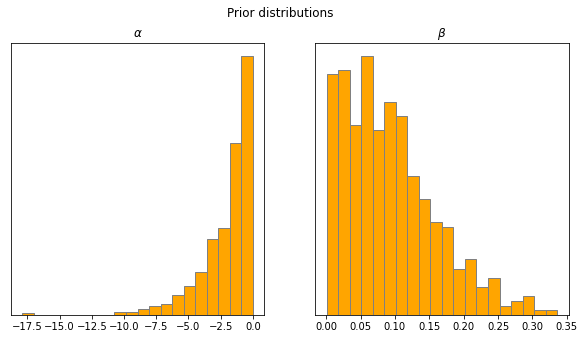

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)
axes_flat = axes.flatten()
ax = axes_flat[0]
ax.hist(alpha_prior_checks,bins=20,color='orange',edgecolor='grey',density=True)
ax.set_title(r'$\alpha$')
ax.set_yticks([])

ax = axes_flat[1]
ax.hist(beta_prior_checks,bins=20,color='orange',edgecolor='grey',density=True)
ax.set_title(r'$\beta$')
ax.set_yticks([])

fig.suptitle('Prior distributions')

plt.show()

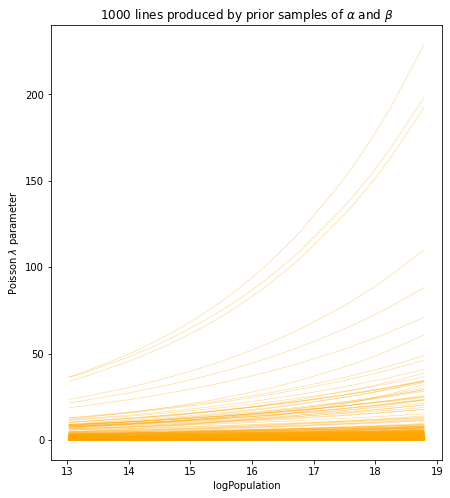

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(7, 8),sharey=True,sharex=True)
ax0=axes
n = 1000
x = np.sort(df.logPopulation)
for i in range(n):
    ax0.plot(x,
              np.exp(alpha_prior_checks[i]+beta_prior_checks[i]*x),
              color='orange',
              alpha=0.5,linewidth=0.5)
ax0.set_ylabel(r'Poisson $\lambda$ parameter')
ax0.set_title(r'{} lines produced by prior samples of $\alpha$ and $\beta$'.format(n))
ax0.set_xlabel('logPopulation')

plt.show()

Most of lines suggest very weak relationship between variables, but some stronger relationships are also possible before seeing data.

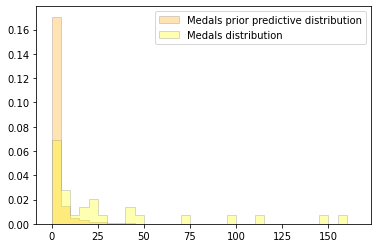

In [17]:
plt.hist(medals_prior_checks.flatten(), histtype='stepfilled', alpha=0.3, color="orange", edgecolor='grey', bins=np.arange(0, 170, 5), density=True)
plt.hist(df.Medals, histtype='stepfilled', alpha=0.3, color="yellow", edgecolor='grey', density=True, bins=np.arange(0, 170, 5))
plt.legend(["Medals prior predictive distribution", "Medals distribution"])
plt.show()

Prior predictive distribution for number of medals suggests that small numbers of them are expected by the model. 

#### Posterior inference

In [18]:
with open('model.stan', 'r') as file:
    print(file.read())

data {
  int N;
  vector[N] x;
  int y[N];
  real<lower=0> lambda_alpha;
  real<lower=0> sigma_beta;
}

parameters {
  real alpha;
  real<lower=0> beta;
}

transformed parameters {
  vector[N] lambda = x*beta-alpha;
}

model {
  alpha ~ exponential(lambda_alpha);
  beta ~ normal(0, sigma_beta);
  y ~ poisson(exp(lambda));
}

generated quantities {
  vector[N] log_lik;
  int y_ppc[N];
  for (i in 1:N) {
    log_lik[i] = poisson_lpmf(y[i] | exp(lambda[i]));
    y_ppc[i] = poisson_rng(exp(lambda[i]));
  }
}


In [19]:
model=CmdStanModel(stan_file='model.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/jaqb/Documents/stan/Data-Analytics-Course/project/model


In [20]:
data_fit=dict(N=len(df),
              x=df.logPopulation.values,
              y=df.Medals.values,
              lambda_alpha=0.5,
              sigma_beta=0.12)

fit_population=model.sample(data=data_fit)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2


In [21]:
alpha_fit = -fit_population.stan_variable('alpha')
beta_fit = fit_population.stan_variable('beta')
medals_fit = fit_population.stan_variable('y_ppc')

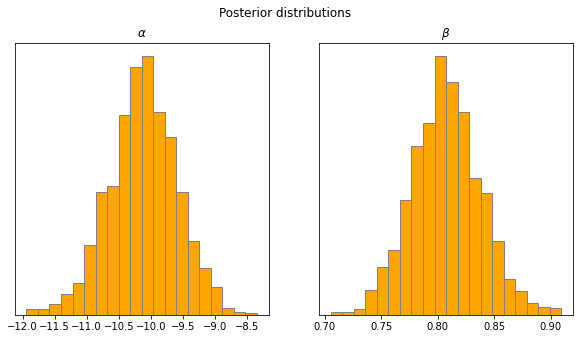

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)
axes_flat = axes.flatten()
ax = axes_flat[0]
ax.hist(alpha_fit,bins=20,color='orange',edgecolor='grey',density=True)
ax.set_title(r'$\alpha$')
ax.set_yticks([])

ax = axes_flat[1]
ax.hist(beta_fit,bins=20,color='orange',edgecolor='grey',density=True)
ax.set_title(r'$\beta$')
ax.set_yticks([])

fig.suptitle("Posterior distributions")
plt.show()

In [23]:
az.summary(dict(alpha=alpha_fit,beta=beta_fit), round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,-10.12,0.53,-11.05,-9.03
beta,0.81,0.03,0.74,0.86


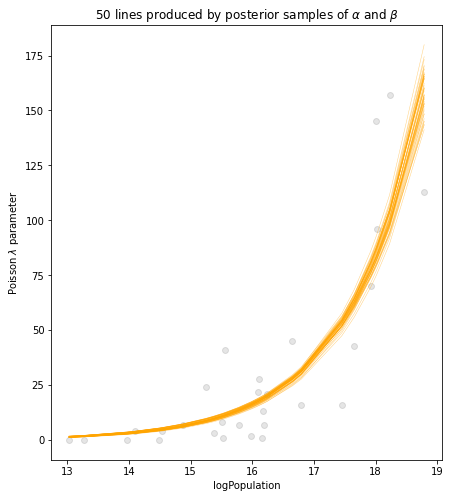

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(7, 8),sharey=True,sharex=True)
ax0=axes
n = 50
x = np.sort(df.logPopulation)
for i in range(n):
    ax0.plot(x,
              np.exp(alpha_fit[i]+beta_fit[i]*x),
              color='orange',
              alpha=0.5,linewidth=0.5)
ax0.scatter(df.logPopulation,df.Medals,color='black',alpha=0.1)
ax0.set_ylabel('Poisson $\lambda$ parameter')
ax0.set_title(r'{} lines produced by posterior samples of $\alpha$ and $\beta$'.format(n))
ax0.set_xlabel('logPopulation')

plt.show()

Even though values for $\beta$ around 0.8 had little prior probability, they were inferred as the most compatible with the data, along with $\alpha$ values of around -10.

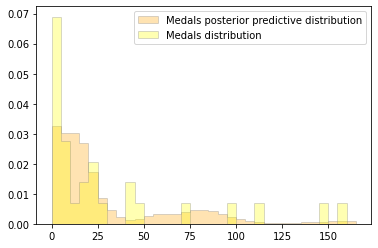

In [25]:
plt.hist(medals_fit.flatten(), histtype='stepfilled', alpha=0.3, color="orange", edgecolor='grey', bins=np.arange(0, 170, 5), density=True)
plt.hist(df.Medals, histtype='stepfilled', alpha=0.3, color="yellow", edgecolor='grey', density=True, bins=np.arange(0, 170, 5))
plt.legend(["Medals posterior predictive distribution", "Medals distribution"])
plt.show()

Posterior predictive distribution for number of medals underestimates smallest numbers of them (0-5) and overestimates slightly bigger numbers (5-20). For bigger values, posterior predictive distribution resembles patterns that can be found in real data. For example, there there are no 115-145 medal numbers in data, and model does not predict any counts there as well. For bigger values, there is some little prediction of them again.

## Predicting number of medals using urbanization of a country

The model looks similar as before:
$$\textrm{Medals}_i\sim\textrm{Poisson}(\lambda_i)$$
$$\textrm{log}(\lambda_i)=\alpha+\beta*\textrm{Urbanization}_i$$
$$-\alpha\sim\textrm{Exponential}(0,5)$$
$$\beta\sim\textrm{Half-Normal}(0, 0.0227)$$
Like before, it is assumed that small value of predictor (close to 0) produces predicted number of medals also around 0. Therefore, prior for $\alpha$ has not been changed. 
The biggest possible urbanization is 100%. For such predictor value, $\beta$ of 0.0682 results in Poisson's $\lambda$ of 918 (assuming $\alpha$=0), so $\sigma$ in Half-Normal prior was set to 0.0.0227 to leave 0.03% probability for less probable values.

#### Prior predictive checks

In [26]:
data_sim = {'N':50, 
            'x':np.linspace(0, 100),
            'lambda_alpha':0.5,
            'sigma_beta':0.0227}
sim = model_ppc.sample(data=data_sim, 
                     iter_sampling=1000, 
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [27]:
alpha_prior_checks = -sim.stan_variable('alpha')
beta_prior_checks = sim.stan_variable('beta')
medals_prior_checks = sim.stan_variable('y')

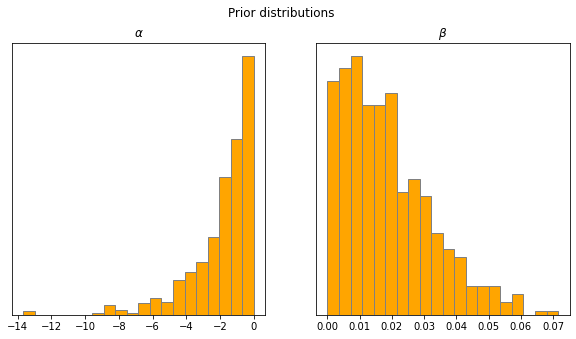

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)
axes_flat = axes.flatten()
ax = axes_flat[0]
ax.hist(alpha_prior_checks,bins=20,color='orange',edgecolor='grey',density=True)
ax.set_title(r'$\alpha$')
ax.set_yticks([])

ax = axes_flat[1]
ax.hist(beta_prior_checks,bins=20,color='orange',edgecolor='grey',density=True)
ax.set_title(r'$\beta$')
ax.set_yticks([])

fig.suptitle('Prior distributions')

plt.show()

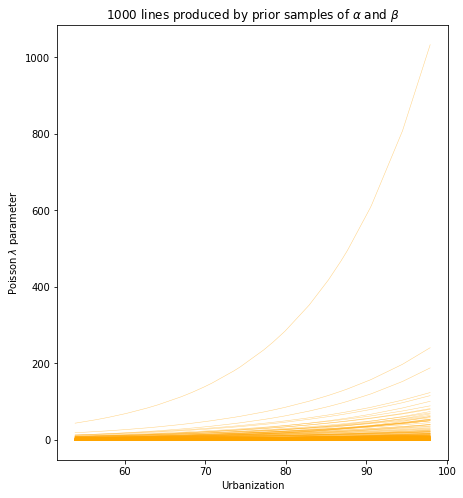

In [29]:
fig, axes = plt.subplots(1, 1, figsize=(7, 8),sharey=True,sharex=True)
ax0=axes
n = 1000
x = np.sort(df.Urbanization)
for i in range(n):
    ax0.plot(x,
              np.exp(alpha_prior_checks[i]+beta_prior_checks[i]*x),
              color='orange',
              alpha=0.5,linewidth=0.5)
ax0.set_ylabel(r'Poisson $\lambda$ parameter')
ax0.set_title(r'{} lines produced by prior samples of $\alpha$ and $\beta$'.format(n))
ax0.set_xlabel('Urbanization')

plt.show()

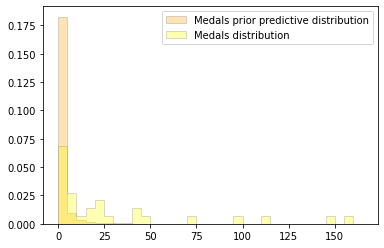

In [30]:
plt.hist(medals_prior_checks.flatten(), histtype='stepfilled', alpha=0.3, color="orange", edgecolor='grey', bins=np.arange(0, 170, 5), density=True)
plt.hist(df.Medals, histtype='stepfilled', alpha=0.3, color="yellow", edgecolor='grey', density=True, bins=np.arange(0, 170, 5))
plt.legend(["Medals prior predictive distribution", "Medals distribution"])
plt.show()

Predicted number of medals based on priors is slightly more concentrated on lower values than before.

#### Posterior inference

In [31]:
data_fit=dict(N=len(df),
              x=df.Urbanization.values,
              y=df.Medals.values,
              lambda_alpha=0.5,
              sigma_beta=0.0227)

fit_urbanization=model.sample(data=data_fit)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4


In [32]:
alpha_fit = -fit_urbanization.stan_variable('alpha')
beta_fit = fit_urbanization.stan_variable('beta')
medals_fit = fit_urbanization.stan_variable('y_ppc')

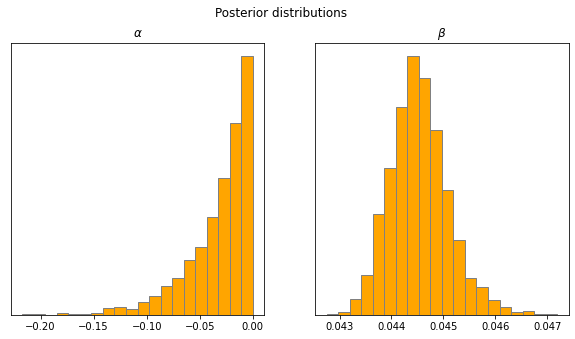

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)
axes_flat = axes.flatten()
ax = axes_flat[0]
ax.hist(alpha_fit,bins=20,color='orange',edgecolor='grey',density=True)
ax.set_title(r'$\alpha$')
ax.set_yticks([])

ax = axes_flat[1]
ax.hist(beta_fit,bins=20,color='orange',edgecolor='grey',density=True)
ax.set_title(r'$\beta$')
ax.set_yticks([])

fig.suptitle("Posterior distributions")
plt.show()

In [34]:
az.summary(dict(alpha=alpha_fit,beta=beta_fit), round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,-0.03,0.03,-0.09,-0.00
beta,0.04,0.00,0.04,0.05


Posterior values for $\alpha$ and $\beta$ are compatible with their priors.

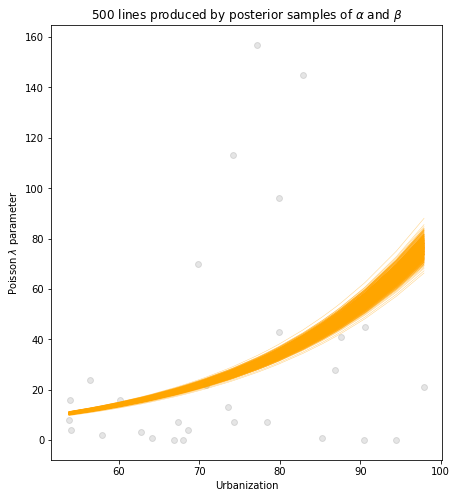

In [35]:
fig, axes = plt.subplots(1, 1, figsize=(7, 8),sharey=True,sharex=True)
ax0=axes
n = 500
x = np.sort(df.Urbanization)
for i in range(n):
    ax0.plot(x,
              np.exp(alpha_fit[i]+beta_fit[i]*x),
              color='orange',
              alpha=0.5,linewidth=0.5)
ax0.scatter(df.Urbanization,df.Medals,color='black',alpha=0.1)
ax0.set_ylabel('Poisson $\lambda$ parameter')
ax0.set_title(r'{} lines produced by posterior samples of $\alpha$ and $\beta$'.format(n))
ax0.set_xlabel('Urbanization')

plt.show()

It seems that the model using urbanization as a predictor, fits data worse. The shape of exponential function is less compatible with the location of datapoints. 

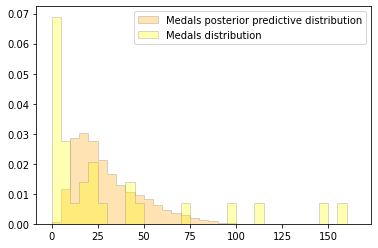

In [36]:
plt.hist(medals_fit.flatten(), histtype='stepfilled', alpha=0.3, color="orange", edgecolor='grey', bins=np.arange(0, 170, 5), density=True)
plt.hist(df.Medals, histtype='stepfilled', alpha=0.3, color="yellow", edgecolor='grey', density=True, bins=np.arange(0, 170, 5))
plt.legend(["Medals posterior predictive distribution", "Medals distribution"])
plt.show()

Posterior predictive distribution drastically underestimates low values of medals. It also does not predict any values above 80, but in reality there are ones.

#### Comparing the models

Preparing InferenceData objects:

In [37]:
population_data = az.from_cmdstanpy(
    posterior=fit_population,
    posterior_predictive="y_ppc",
    observed_data={"y": df["Medals"].values},
    log_likelihood="log_lik"
)

In [38]:
urbanization_data = az.from_cmdstanpy(
    posterior=fit_urbanization,
    posterior_predictive="y_ppc",
    observed_data={"y": df["Medals"].values},
    log_likelihood="log_lik"
)

Comparing models using Arviz.compare():

In [39]:
compare_dict = {"population": population_data, "urbanization": urbanization_data}
az.compare(compare_dict, ic="loo")

/home/jaqb/anaconda3/envs/stanEnv/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/jaqb/anaconda3/envs/stanEnv/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/jaqb/anaconda3/envs/stanEnv/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to wo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
population,0,-237.650103,29.715040,0.000000,0.719951,39.900423,0.00000,True,log
urbanization,1,-767.193796,59.093547,529.543693,0.280049,179.118509,169.06901,True,log


Both models got warnings about high Pareto values for some samples. There are highly influential outliers in the sample and it is difficult to estimate predictive accuracy. Computations might not be reliable.<br>
Population model got better LOO result than the one using urbanization as a predictor. Urbanization model is more than 500 units of deviance higher than the population one. Effective number of parameters accounts to around 30 in case of the population model and 59 in case of the urbanization one.<br>
The difference in loo values along with standard errors suggest that the population model is better in predicting number of medals.